<a href="https://colab.research.google.com/github/mahoneynomadic/mathematical_aspects_of_machine_learning/blob/main/session4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mathematical aspects of Machine Learning: exercise sheet 4

Lecturers: Péter Koltai, Mattes Mollenhauer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

In [2]:
%matplotlib inline

## Exercise 1c

We generate a dataset by first drawing from a uniform distribution on $[-1 ,1]^2$ and then
for each sampled point deciding via sampling of an auxiliary variable whether a class label $+1$ or $-1$ is attached to this data point.

In [3]:
def generate_data(l, plot=True, exercise_1g=False):
    '''
    returns (2,l)-shaped float data array X and {+/-1} Y label vector
    corresponding to distributions given in the exercise
    '''
    Y = []
    X = np.random.uniform(low=-1.0,high=1.0,size=(l,2))
    #generate Y
    for x in X:
        decision_variable=np.random.uniform(low=0,high=1.0)
        if exercise_1g:
            threshold = 1/4 * (x[0] + 1) * (x[1] + 1)
        else:
            threshold = (x[0]+1)/2.0
        if decision_variable <= threshold:
            Y.append(1)
        else:
            Y.append(-1)
    if plot:
        plt.scatter(X[:,0],X[:,1],c=Y,cmap='viridis')
        plt.show()
    
    return X, np.array(Y)

Visualization of the samples: yellow corresponds to labels $+1$.

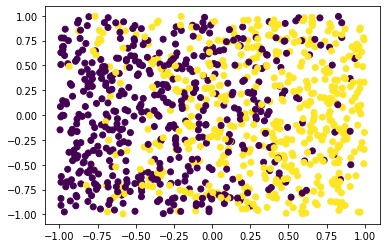

In [4]:
X, Y = generate_data(1000)

We can easily sample the Bayes risk (note that the Bayes classifier is given by the $y$-axis as decision boundary, it decides $+1$ for positive $x$ values.)

In [5]:
def mc_bayes_risk(n_data):
    """
    Samples the risk of the Bayes classifier.
    """
    X,Y = generate_data(n_data, plot=False)
    bayes_predictions = np.array([1 if x[0] > 0 else -1 for x in X])
    misclassified = np.sum((Y != bayes_predictions))
    return misclassified / n_data

mc_bayes_risk(10000)

0.2493

In [6]:
def brute_force_model(X, Y):
    '''
    performs brute force linear classifier search with respect to classical empirical risk on 2d data
    input: 
        X: (2,l)-shaped float data array 
        Y: {+/-1} label vector
    
    output:
        stored classifications: data label vector of best performing classifier
        stored_weight: 2d weight vector corresponding to best linear classifier
        stored_bias: bias of  best linear classifier
    '''
    
    l = X.shape[0]
    
    stored_empirical_risk = 1 #initial risk, assume everything to be classified falsely
    
    #iterate over all point pairs (note: order (a,b),(b,a) is important
    #to distinguish between w and -w, therefore 2*C(l,2) possible pairs)
    for choice in permutations(X, r=2):
        
        #get difference vector
        diff = choice[1]-choice[0]
        #rotate by 90 degrees
        w = np.array([-1 * diff[1] , diff[0]])
        bias = -1 * np.dot(w, choice[0])
        #define classifier and evaluate
        f = lambda x: np.sign(np.dot(w, x) + bias)
        classifications = np.apply_along_axis(f, axis=1, arr=X)
        classifications[classifications == 0] = 1.0 #workaround np.sign(0) = 0
        empirical_risk = 1 - (np.sum(np.equal(Y, classifications))/l)
        
        #best performing classifier is kept
        if empirical_risk <= stored_empirical_risk:
                
            stored_weight = w
            stored_bias = bias
            stored_empirical_risk = empirical_risk
            stored_classifications = classifications
        
    return stored_classifications, stored_weight,stored_bias, stored_empirical_risk                   

Lets prepare an auxiliary function for running the model and visualizing the data and decision boundary.

In [7]:
from sympy import symbols
from sympy.solvers.solveset import linsolve
from sympy import plot,solve

def run_ex(l): 
    print('generating data... \n')
    X,Y = generate_data(l)
    print('brute force model search... \n')
    c,w,b,er = brute_force_model(X,Y)
    print('brute force model empirical risk: %f \n' %er)
    x, y = symbols('x, y')
    solution = solve([w[0]*x+w[1]*y+b], (x, y))
    solfunc = solution[x]
    eval_vec = np.linspace(np.min(X[:,1]),np.max(X[:,1]),10)
    solutions = [solfunc.subs(y,i) for i in eval_vec]
    plt.plot(solutions,eval_vec)
    plt.scatter(X[:,0],X[:,1],c=Y,cmap='viridis')
    plt.gca().set_xlim((-1.5,1.5))
    plt.gca().set_ylim((-1.5,1.5))
    plt.title('')
    plt.show()    

Now we run the brute force search on our randomly generated dataset and visualize the solutions.

generating data... 



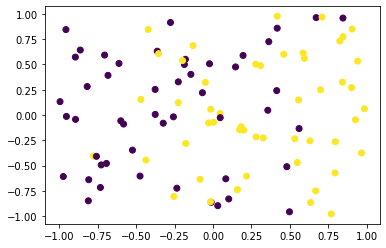

brute force model search... 

brute force model empirical risk: 0.230000 



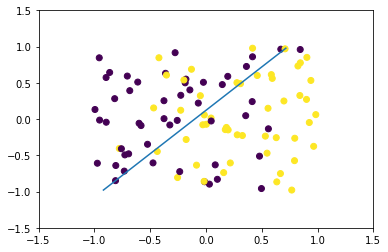

In [8]:
run_ex(100)

## Exercise 1d)

For convenience, we choose the classifier defined by
$w = (1,-1)$ and $b = 0$ here. 
This allows us to simplify the analytical integration over the triangular areas defined
by the decision boundary $ x = y $. Of course, the same approach works just as fine
whenever a different weight and bias introduce a different decision boundary. In this case, the two areas are defined by $y = mx + n$ where $m$ and $n$ depend on $w$ and $b$.

The values of $w$ and $b$ can be modified arbitrarily in the cell below.
We just assume we observed a dataset such that this classifier was the empirical optimal rule.
To use the classifier obtained from the brute force optimization above, just extract the weights and bias from the model run.

We plot the resulting classifier together with the previously generated data.

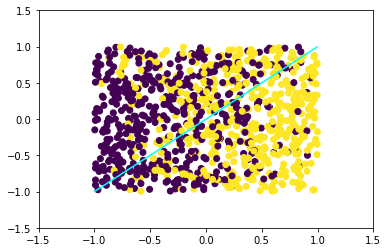

In [9]:
w = np.array([1, -1])
b = 0

x, y = symbols('x, y')
solution = solve([w[0]*x+w[1]*y+b], (x, y))
solfunc = solution[x]
eval_vec = np.linspace(np.min(X[:,1]),np.max(X[:,1]),10)
solutions = [solfunc.subs(y,i) for i in eval_vec]
plt.plot(solutions,eval_vec, c="cyan")
plt.scatter(X[:,0],X[:,1],c=Y,cmap='viridis')
plt.gca().set_xlim((-1.5,1.5))
plt.gca().set_ylim((-1.5,1.5))
plt.title('')
plt.show()

We sample the generalization error by computing an empirical risk with a large sample number on a newly generated dataset.

In [10]:
def mc_generalization_error(w, bias, n_samples):
    """
    Samples the generalization error for a classifier
    defined by coefficients w, b based on 
    a dataset of size n_samples
    """
    X, Y = generate_data(n_samples, plot=False)
    #define classifier and evaluate
    f = lambda x: np.sign(np.dot(w,x) + bias)
    classifications = np.apply_along_axis(f,axis=1, arr=X)
    classifications[classifications == 0] = 1.0 #workaround np.sign(0) = 0
    empirical_risk = 1 - (np.sum(np.equal(Y, classifications))/n_samples)
    return empirical_risk

mc_generalization_error(w, b, 100)

0.24

As expected, the sampled generalization error comes close to the analytically computed generalization error.

## Exercise 1g)

Just run this notebook by setting the `exercise_1g` flag in the data generation function at the beginning to `True`.

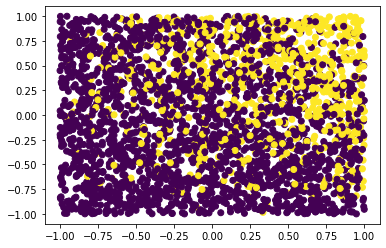

In [11]:
X, Y = generate_data(3000, exercise_1g=True)